In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def read_seqs(filename):
    seqs = {}
    with open(filename) as inp:
        header = ''
        for line in inp:
            line = line.strip()
            if line.startswith('>'):
                header = line
                seqs[header] = seqs.get(header, '')
            else:
                seqs[header] += line
    return seqs
        

In [23]:
seqs = read_seqs("Pepeliaeva-full-180.fasta")


In [47]:
domain_seqs = []
with open('domain_seq.txt') as inp:
    for line in inp:
        line = line.strip().split()[0]
        domain_seqs += [line]

In [157]:
ACs = []
all_ACs = []
with open('seq_domains.fasta', 'w') as out:
    for key, value in seqs.items():
        h = key.split()[0][1:]
        all_ACs += [h]
        for header in domain_seqs:
            if header in key:
                ACs += [header]
                print('>'+header, file=out)
                for i in range(0, len(value), 75):
                    print(value[i:i+75], file=out, end='\n')

In [149]:
# результаты поиска, обрезаются при E-value > 10
with open('out.txt') as f:
    df = pd.read_csv(f, delimiter='\t')

In [150]:
df

AC            ID  Score        E-value  N
0    A0A4Q4SY26_9PEZI  (A0A4Q4SY26)  436.2  9.100000e-130  1
1    A0A4Q4VI87_9PEZI  (A0A4Q4VI87)  422.0  1.600000e-125  1
2    A0A4Q4SWL3_9PEZI  (A0A4Q4SWL3)  419.1  1.300000e-124  1
3    A0A4Q4Y7K0_9PEZI  (A0A4Q4Y7K0)  417.0  5.200000e-124  1
4        F9G5Y7_FUSOF      (F9G5Y7)  414.1  3.800000e-123  1
..                ...           ...    ...            ... ..
164  A0A7C8MMC2_9PEZI  (A0A7C8MMC2) -140.0   4.800000e+00  1
165      Q2U5L9_ASPOR      (Q2U5L9) -141.8   6.200000e+00  1
166  A0A0W0EYB3_9AGAR  (A0A0W0EYB3) -143.3   7.600000e+00  1
167  A0A7H8R849_9EURO  (A0A7H8R849) -143.4   7.700000e+00  1
168  A0A098DFR3_GIBZE  (A0A098DFR3) -144.4   8.800000e+00  1

[169 rows x 5 columns]

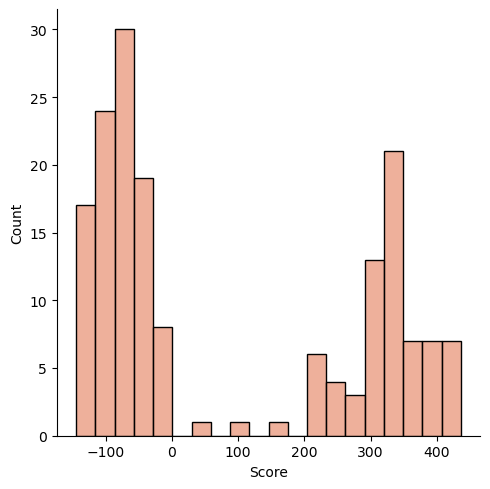

In [122]:
sns.displot(df['Score'], color='darksalmon', bins=20)
plt.show()

In [248]:
with open('table.tsv', 'w') as res:
    headers = ['AC', 'Contains architecture', 'Was used for HMM profile building','Score', 'E-value', 'TPR', '1 - TNR']
    table_df = pd.DataFrame(columns=headers)
    table_df['AC'] = df['AC']
    if_contains = [el in ACs for el in df['AC']]
    table_df['Contains architecture'] = if_contains
    

In [249]:
corrected_seqs = read_seqs('corrected.fa')
used_for_HMM = [k.split('/')[0][1:] for k in list(corrected_seqs.keys())]

In [250]:
used = [el in used_for_HMM for el in df['AC']]
table_df['Was used for HMM profile building'] = used

In [251]:
table_df['Score'] = df['Score']

In [252]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(table_df['Contains architecture'], table_df['Score'])

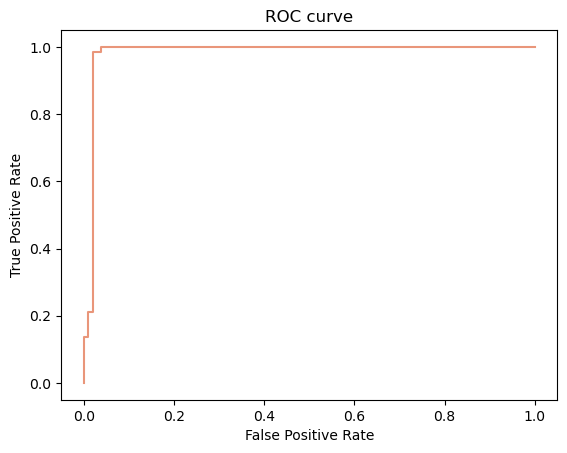

In [253]:
plt.plot(fpr,tpr, color='darksalmon')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.show()

In [254]:
# table_df['TPR'] = tpr
# table_df['FPR'] = fpr
# table_df
y_true = table_df['Contains architecture']

In [255]:
tprs = []
SPC = []
TPR = []
FS = []
for score in table_df['Score']:
    y_pred = table_df['Score'].apply(lambda x: x >= score)
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    TPR.append(tp / (tp + fn))
    SPC.append(1 - tn / (tn + fp))
    FS.append(2 * tp / (2*tp + fp + fn))

In [256]:
table_df['TPR'] = TPR
table_df['1 - TNR'] = SPC
table_df['E-value'] = df['E-value']
table_df['F1'] = FS

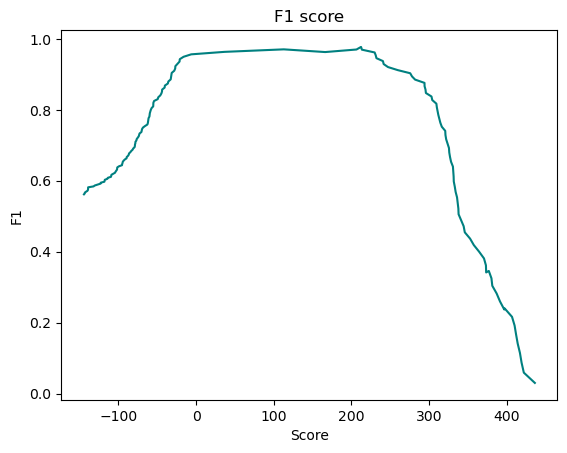

In [257]:
sns.lineplot(x=table_df['Score'], y=table_df['F1'], color='teal')
plt.title('F1 score')
plt.show()

In [258]:
table_df

AC  Contains architecture  \
0    A0A4Q4SY26_9PEZI                   True   
1    A0A4Q4VI87_9PEZI                   True   
2    A0A4Q4SWL3_9PEZI                   True   
3    A0A4Q4Y7K0_9PEZI                   True   
4        F9G5Y7_FUSOF                   True   
..                ...                    ...   
164  A0A7C8MMC2_9PEZI                  False   
165      Q2U5L9_ASPOR                  False   
166  A0A0W0EYB3_9AGAR                  False   
167  A0A7H8R849_9EURO                  False   
168  A0A098DFR3_GIBZE                  False   

     Was used for HMM profile building  Score        E-value       TPR  \
0                                 True  436.2  9.100000e-130  0.015152   
1                                 True  422.0  1.600000e-125  0.030303   
2                                False  419.1  1.300000e-124  0.045455   
3                                 True  417.0  5.200000e-124  0.060606   
4                                 True  414.1  3.800000e-123  0.075758   
..                                 ...    ...            ...       ...   
164                              False -140.0   4.800000e+00  1.000000   
165                              False -141.8   6.200000e+00  1.000000   
166                              False -143.3   7.600000e+00  1.000000   
167                              False -143.4   7.700000e+00  1.000000   
168                              False -144.4   8.800000e+00  1.000000   

      1 - TNR        F1  
0    0.000000  0.029851  
1    0.000000  0.058824  
2    0.000000  0.086957  
3    0.000000  0.114286  
4    0.000000  0.140845  
..        ...       ...  
164  0.961165  0.571429  
165  0.970874  0.568966  
166  0.980583  0.566524  
167  0.990291  0.564103  
168  1.000000  0.561702  

[169 rows x 8 columns]

In [259]:
table_df.to_csv('table.tsv', sep='\t')